# Clean up
Use a reference static coast line to clean up the combined GL file for the whole ice sheet.

In [70]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon,LineString,MultiPolygon

Read the combined GL file:

In [2]:
#-- GL shapefile
INFILE = os.path.expanduser('~/GL_learning_data/combined_AllTracks.shp')
#-- read GLs
gls = gpd.read_file(INFILE)

## 1) Make mask file
Read reference file (GSHHS coast line with full resolution)

In [91]:
#-- also read reference file
ref1 = gpd.read_file(os.path.expanduser('~/data.dir/coasts.dir/GSHHS.dir/GSHHS_h_L6.shp'))

In [93]:
ref1 = ref1.to_crs(gls.crs)

In [113]:
#-- set max distance threshold (15 km)
thresh = 50e3

Make sure both projections are in polar stereographic.

In [114]:
plist = [None]*len(ref1)
for i in range(len(ref1)):
    plist[i] = LineString(ref1['geometry'][i].exterior).buffer(thresh)

In [115]:
mask = MultiPolygon(plist)

In [109]:
mask

In [116]:
#-- save mask to file
out_df = {}
out_df['geometry'] = mask
out_df['id'] = 0
out_df = gpd.GeoDataFrame(pd.DataFrame(out_df))

In [117]:
out_df.crs = gls.crs

In [98]:
out_df

,geometry,id
0,"POLYGON ((-5000 -6.123233995736766e-13, -5000 ...",0
1,POLYGON ((-2511560.966129937 1387225.364876108...,0
2,"POLYGON ((-2208121.65808689 735466.8097366486,...",0
3,POLYGON ((-988700.0132081441 887840.6192048062...,0
4,POLYGON ((-1982575.005437186 -299228.958338476...,0
...,...,...
340,POLYGON ((-735296.3783188183 -1225753.71120901...,0
341,POLYGON ((-1838360.626357954 -242813.943597650...,0
342,POLYGON ((-421872.0929812951 1913571.155047707...,0
343,POLYGON ((-1843740.535067844 -216033.686299076...,0


In [118]:
out_df.to_file(os.path.expanduser('~/GL_learning_data/ais_mask_%ikm.shp'%(thresh/1000)),driver='ESRI Shapefile')

## Test multipoylgon intersection

In [6]:
p1 = Polygon([[0,0],[0,1],[1,1],[1,0],[0,0]])

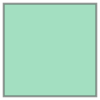

In [10]:
p2

In [8]:
p2 = Polygon([[3,3],[3,4],[4,4],[4,3],[3,3]])

In [12]:
l1 = LineString([[10,10],[20,10]])

In [13]:
l2 = LineString([[0.5,0.5],[2,0.5]])

In [22]:
l3 = LineString([[0.5,0.5],[0.7,0.5]])

In [38]:
p1.contains(l2)

False

In [37]:
p1.contains(l3)

True

In [39]:
p1.intersects(l2)

True

In [26]:
mps = MultiPolygon([p1,p2])

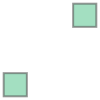

In [28]:
mps

In [36]:
mps.intersects(l2)

True

## 2) Read mask file and clean up GLs

In [119]:
mask = gpd.read_file(os.path.expanduser('~/GL_learning_data/ais_mask_15km.shp'))

In [5]:
mask

,id,geometry
0,0,"POLYGON ((-15000 -1.83697019872103e-12, -15000..."
1,0,POLYGON ((-2520910.869306356 1383170.111886807...
2,0,POLYGON ((-2218177.368854853 735395.8061220336...
3,0,POLYGON ((-998605.1017735566 889618.2535033845...
4,0,POLYGON ((-1992167.127112929 -295520.928495897...
...,...,...
340,0,POLYGON ((-743739.0883619763 -1220411.06564015...
341,0,POLYGON ((-1840681.778457534 -233091.849540329...
342,0,POLYGON ((-421716.2843583747 1923563.503092881...
343,0,POLYGON ((-1834071.599010193 -213501.049760835...


In [120]:
mm = MultiPolygon(mask['geometry'].tolist())

In [121]:
len(mm)

345

In [143]:
%%timeit
remove_ind = []
for i in np.arange(20):#range(len(gls)):
    int_list = [mask['geometry'][j].intersects(gls['geometry'][i]) for j in range(len(mm))]
    if np.count_nonzero(int_list) == 0:
        #-- if none intersect, add to remove list.
        remove_ind.append(i)

343 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
print(remove_ind)

[9]


In [137]:
%%timeit
remove_ind = []
for i in np.arange(20):#range(len(gls)):
    if True not in [mask['geometry'][j].intersects(gls['geometry'][i]) for j in range(len(mm))]:
        remove_ind.append(i)

339 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [138]:
print(remove_ind)

[9]


In [139]:
%%timeit
remove_ind = []
for i in np.arange(20):#range(lebn(gls)):
    if np.count_nonzero([mask['geometry'][j].intersects(gls['geometry'][i]) for j in range(len(mm))])==0:
        remove_ind.append(i)

351 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [140]:
print(remove_ind)

[9]


In [154]:
%%timeit
remove_ind = []
for i in np.arange(30):#range(len(gls)):
    rm = True
    for j in range(len(mask)):
        if mask['geometry'][j].intersects(gls['geometry'][i]):
            rm = False
            break
    if rm:
        remove_ind.append(i)

362 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [155]:
print(remove_ind)

[9]


In [156]:
%%timeit
n = len(mask)
remove_ind = []
for i in np.arange(30):#range(len(gls)):
    rm = True
    j = 0
    while rm and j < n:
        if mask['geometry'][j].intersects(gls['geometry'][i]):
            rm = False
        j += 1
    if rm:
        remove_ind.append(i)

360 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [157]:
print(remove_ind)

[9]


In [ ]:
#-- remove extra elements
gls = gls.drop(remove_ind)

In [ ]:
#-- save to file
gls.to_file(os.path.expanduser('~/GL_learning_data/combined_AllTracks_cleaned.shp'),driver='ESRI Shapefile')